- 개별 칼럼을 들여다볼 시간이 없음
- int와 float, cate로 나눠서 경향성만 살펴봄
- 각 관측치에 대해 통계치만 뽑아 피쳐로 활용하기로 결정

In [1]:
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_path = "../take-home-interview/"

In [3]:
app = pd.read_csv(data_path + "loan_application.csv")
app_prev = pd.read_csv(data_path + "application_previous.csv")

In [4]:
## mark target
n_before = len(app_prev)
app_prev = app_prev.merge(app[['application_id_current', 'target']], on='application_id_current')
n_after = len(app_prev)
decrease_ratio = (n_before - n_after) / n_before

print(f"n: {n_before:,} -> {n_after:,} after merge ({decrease_ratio*100:.2f}% decrease)")

n: 1,670,214 -> 1,670,214 after merge (0.00% decrease)


## Analysis

In [5]:
## 중복 없음
app_prev.groupby(['application_id_current', 'application_id_previous']).size().nlargest()

application_id_current  application_id_previous
100001                  1369693                    1
100002                  1038818                    1
100003                  1810518                    1
                        2396755                    1
                        2636178                    1
dtype: int64

<AxesSubplot:>

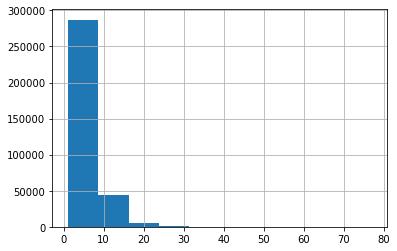

In [6]:
app_prev.groupby("application_id_current").size().hist()

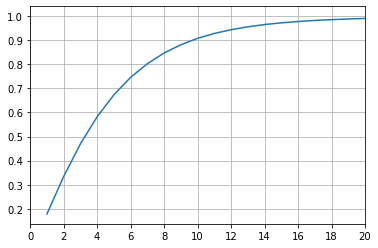

In [122]:
## 대부분 2개 이상을 가지고 있다
app_prev.application_id_current.value_counts().value_counts(normalize=True).sort_index().cumsum().plot()
plt.xlim(0, 20)
plt.yticks(np.arange(0.2, 1.1, .1))
plt.xticks(np.arange(0, 22, 2))
plt.grid()
plt.show()

In [28]:
pd.options.display.float_format = '{:,.4f}'.format

In [33]:
na_df = app_prev.isna().mean()
no_missing_column_count = (na_df==0).sum() 
print(f"no missing column count: {no_missing_column_count}({no_missing_column_count/len(na_df)*100:.2f}%)")
na_df[na_df>0].sort_values(ascending=False)

no missing column count: 19(54.29%)


rate_interest_primary       0.9964
rate_interest_privileged    0.9964
amt_down_payment            0.5364
rate_down_payment           0.5364
name_type_suite             0.4912
days_first_drawing          0.4030
days_first_due              0.4030
days_last_due_1st_version   0.4030
days_last_due               0.4030
days_termination            0.4030
nflag_insured_on_approval   0.4030
amt_goods_price             0.2308
amt_annuity                 0.2229
cnt_payment                 0.2229
target                      0.1536
amt_credit                  0.0000
dtype: float64

In [100]:
int_cols = app_prev.dtypes[app_prev.dtypes == int].index
float_cols = app_prev.dtypes[app_prev.dtypes == float].index
cate_cols = app_prev.dtypes[app_prev.dtypes == 'object'].index

## 칼럼 예외 처리
int_cols = [col for col in int_cols if 'id' not in col]
float_cols = [col for col in float_cols if col != 'target']

In [101]:
print(f"integer feature count: {len(int_cols)}")
print(f"float feature count: {len(float_cols)}")
print(f"category feature count: {len(cate_cols)}")

integer feature count: 4
float feature count: 16
category feature count: 13


**Numeric**

In [102]:
def hist_by_target(app_prev, col:str, log_scaled:bool=False, bins=20):
    leg = []
        
    for target, group in app_prev.groupby("target"):
        col_series = group[col]
        if log_scaled:

            col_min = col_series.min()
            if col_min <= 0:
                col_series = col_series - col_min + 1
            col_series = col_series.apply(np.log)
        col_series.hist(density=True, alpha=0.5, bins=bins)
        col_mean = col_series.mean() 
        leg.append(f"{target}(mean={col_mean:.1f})")
    plt.title(col)
    plt.legend(leg)
    plt.show()

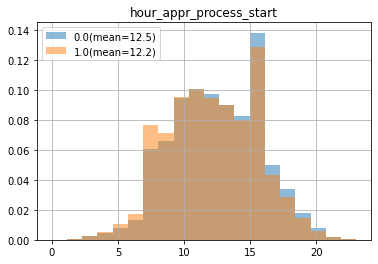

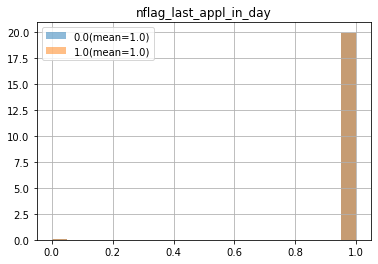

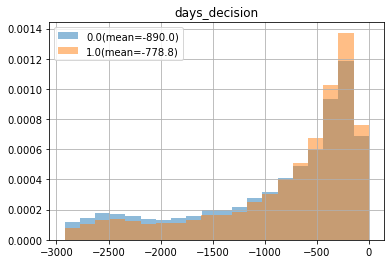

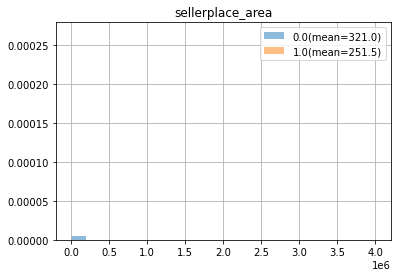

In [104]:
for int_col in int_cols:
    hist_by_target(app_prev, int_col)

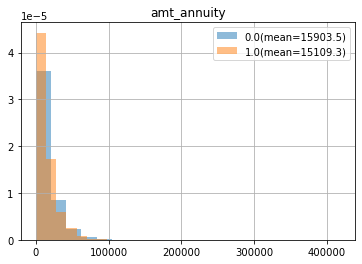

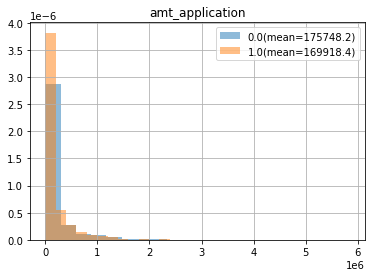

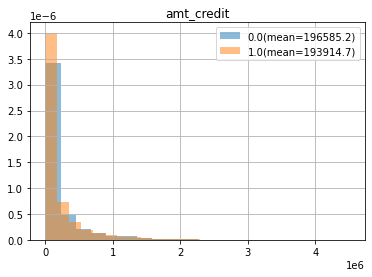

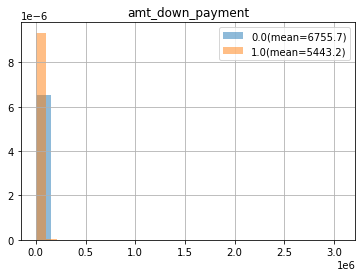

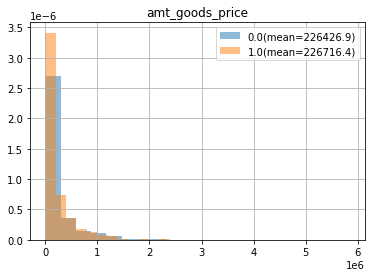

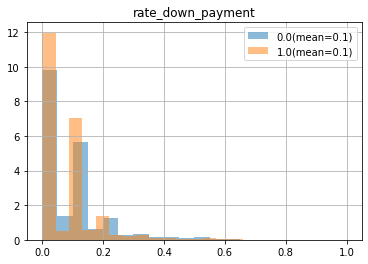

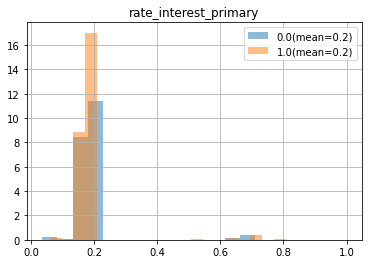

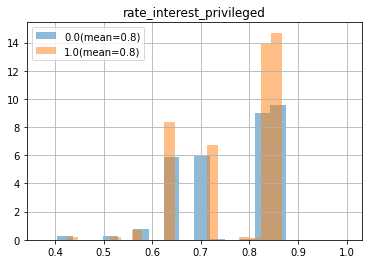

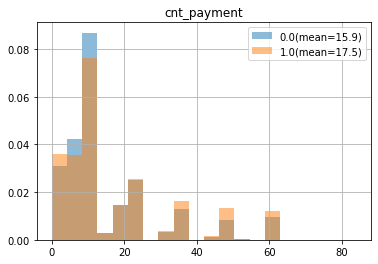

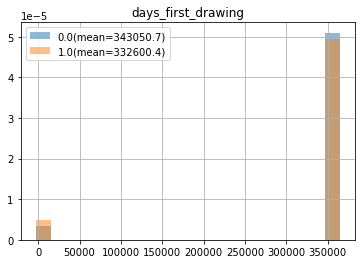

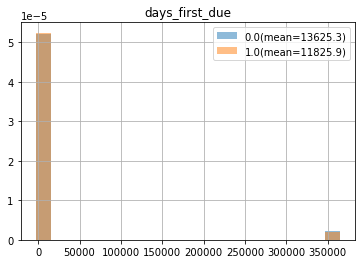

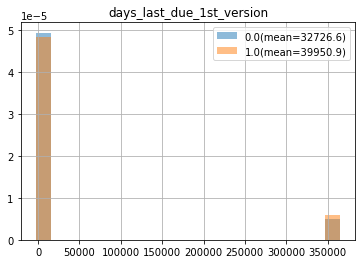

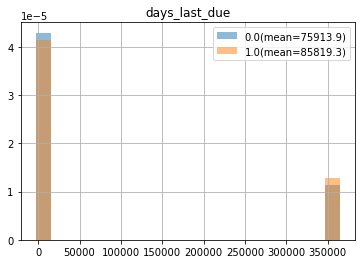

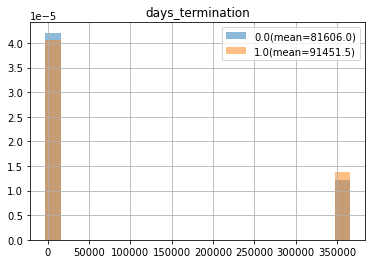

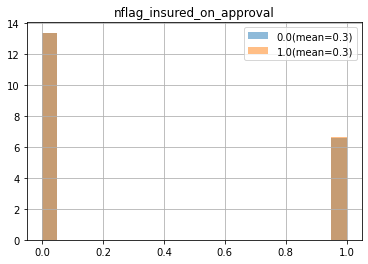

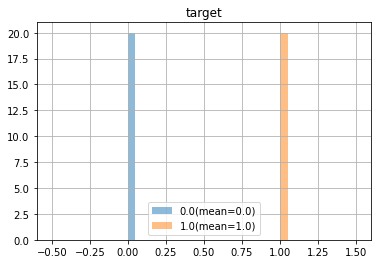

In [109]:
for float_col in float_cols:
    hist_by_target(app_prev, float_col)

In [130]:
def hist_by_target_id_grouped(app_prev, col:str, log_scaled:bool=False, bins=20):
    leg = []
    if app_prev[col].max() > 1E+4:
        log_scaled = True
        
    for target, group in app_prev.groupby("target"):
        col_series = group.groupby("application_id_current")[col].mean()
        if log_scaled:

            col_min = col_series.min()
            if col_min <= 0:
                col_series = col_series - col_min + 1
            col_series = col_series.apply(np.log)
        col_series.hist(density=True, alpha=0.5, bins=bins)
        col_mean = col_series.mean() 
        leg.append(f"{target}(mean={col_mean:.1f})")
    plt.title(col)
    plt.legend(leg)
    plt.show()

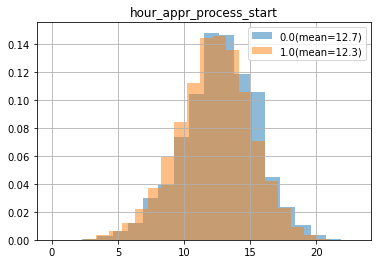

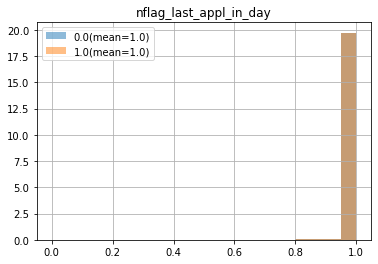

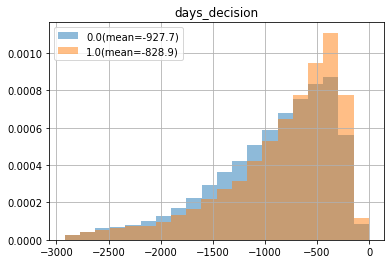

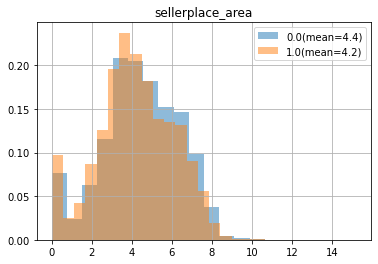

In [131]:
for int_col in int_cols:
    hist_by_target_id_grouped(app_prev, int_col)

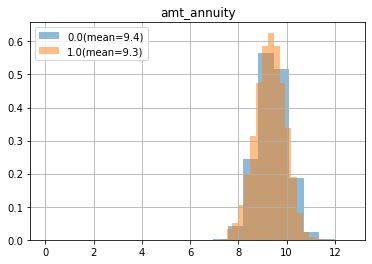

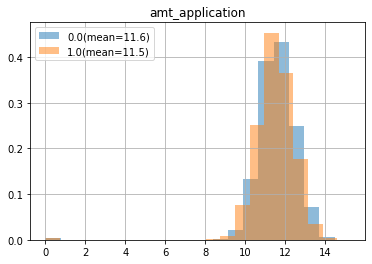

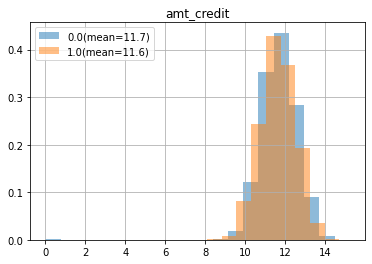

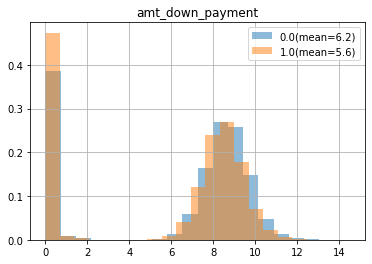

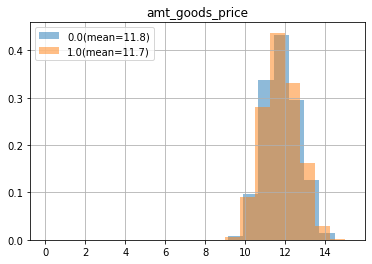

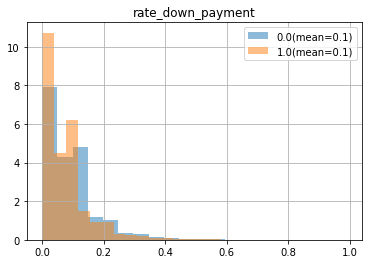

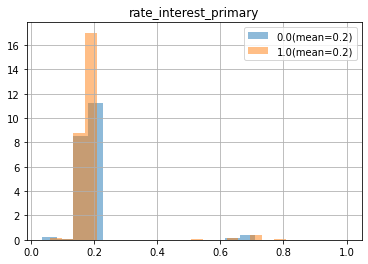

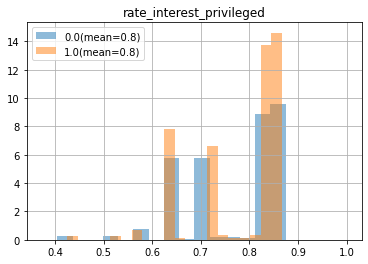

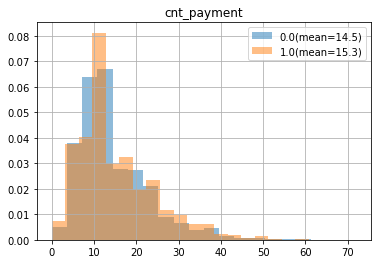

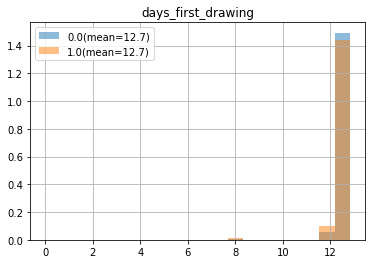

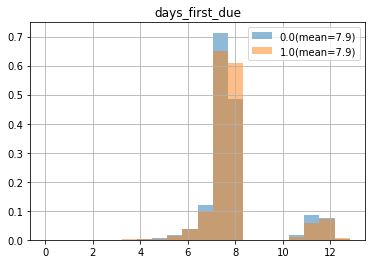

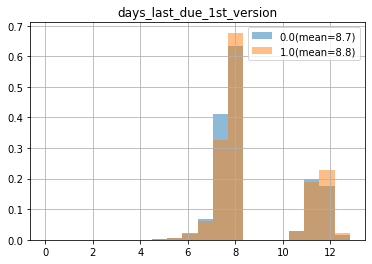

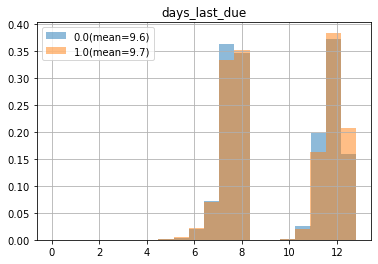

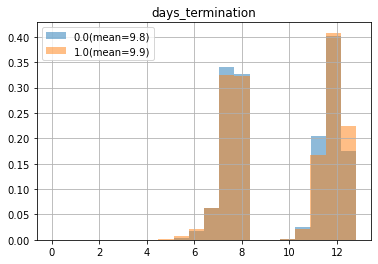

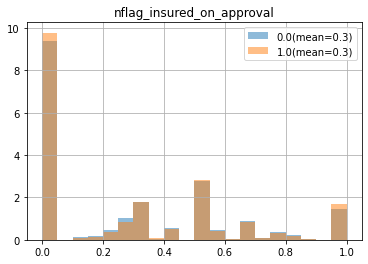

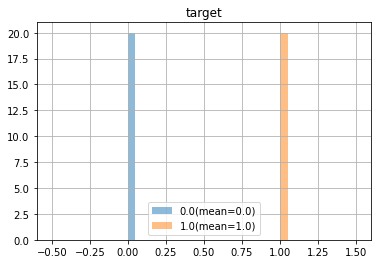

In [132]:
for int_col in float_cols:
    hist_by_target_id_grouped(app_prev, int_col)

### Categories

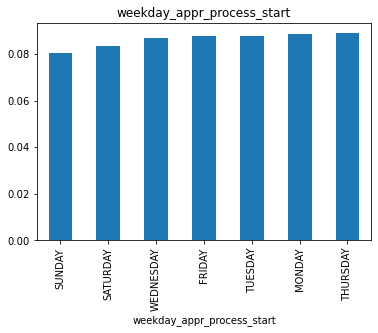

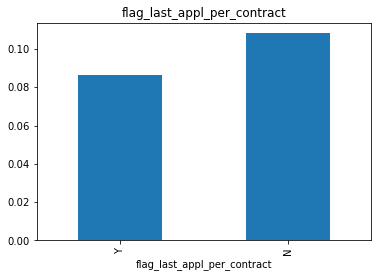

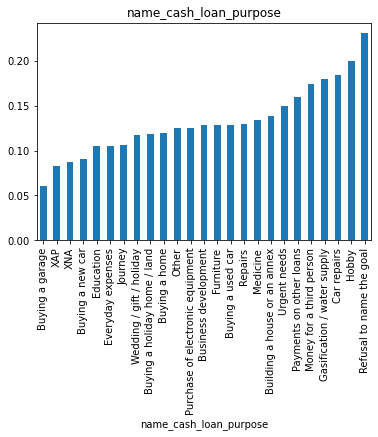

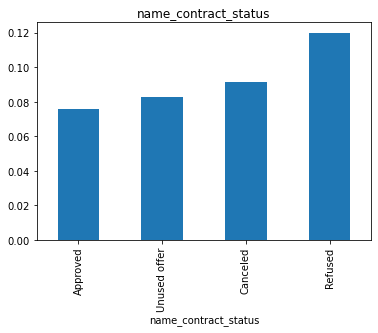

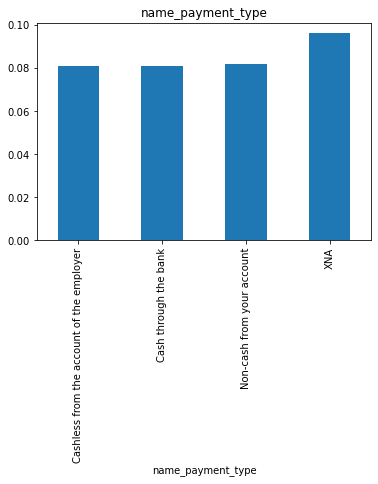

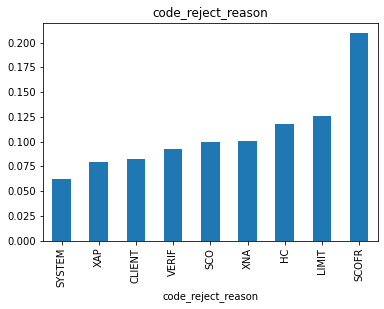

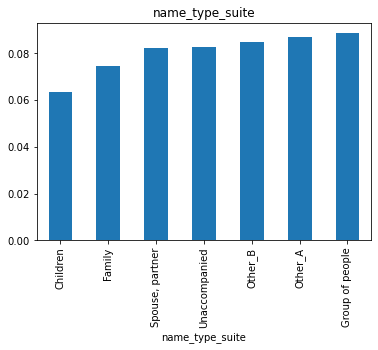

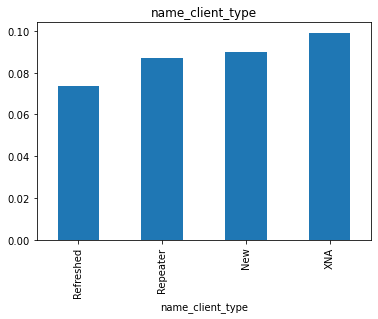

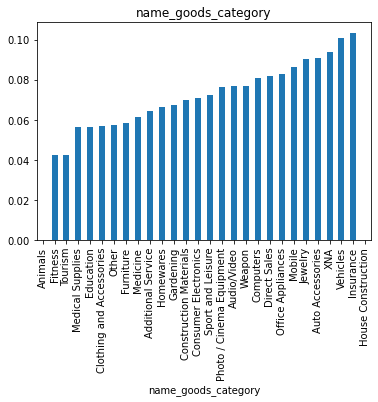

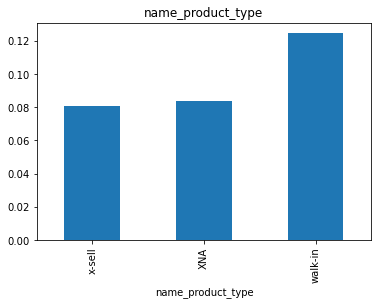

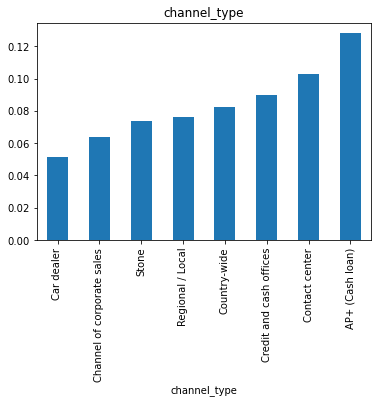

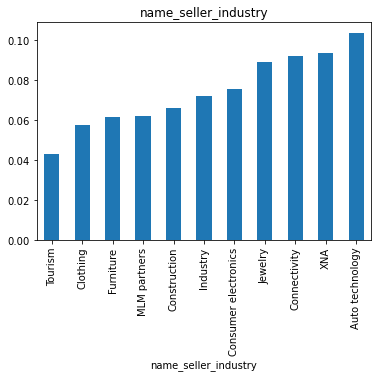

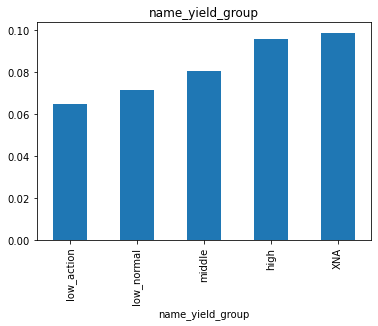

In [87]:
for cate_col in cate_cols:
    app_prev.groupby(cate_col).target.mean().sort_values().plot.bar()
    plt.title(cate_col)
    plt.show()